# 指定CPU跑

In [1]:

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# tensorflow2.0
import tensorflow as tf
from tensorflow.keras import Input,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

x_train = x_train[:2000]
x_test = x_test[:1000]
print( x_train.shape)
print( x_test.shape)

(10000, 28, 28, 1)
(1000, 28, 28, 1)


In [26]:


import cv2
X_train, X_test = x_train[0][...,-1], x_test[0][...,-1]
print(X_test.shape)
X_train, X_test = cv2.resize(X_train, (128,128)), cv2.resize(X_test, (128,128))
X_train, X_test = X_train.reshape(1,128,128,1), X_test.reshape(1,128,128,1)
for i, j in zip(x_train, x_test):
    x_i = cv2.resize(i[...,-1], (128, 128))
    x_j = cv2.resize(j[...,-1], (128, 128))
    X_train = np.concatenate((X_train, x_i.reshape(1,128,128,1)), axis=0)
    X_test = np.concatenate((X_test, x_j.reshape(1,128,128,1)), axis=0)


(28, 28)


In [27]:
print(X_test.shape)
print(X_train.shape)

(1001, 128, 128, 1)
(1001, 128, 128, 1)


In [1]:
import glob
data_path = glob.glob(r'D:\BaiduNetdiskDownload\CelebA\Img\img_align_celeba\img_align_celeba\*')

import cv2
a = cv2.imread(data_path[0], 0)

w, h = 256,256
DATA = np.random.rand(1,w,h,1)
for i in data_path[:100]:
    read_i = cv2.imread(i, 0)
    read_i=cv2.resize(read_i, (128,128))
    DATA = np.concatenate([DATA, read_i.reshape(1,w,h,1)], axis=0)

x_train = DATA[:150]
x_test = DATA[-20:]

In [75]:
w, h = 128,128

# encoder maxpooling decoder upSampling

In [72]:

input_img = Input(shape=(w,h, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') # keras use this 
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # tf.keras use this
autoencoder.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 2, 2, 1)]         0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 2, 2, 16)          160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 1, 1, 8)           1160      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 1, 8)           0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 1, 1, 8)           584       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 8)           0  

# 全卷积: 容易造成棋盘现象

In [64]:

input_img = Input(shape=(w,h, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3),strides=(2,2), activation='relu', padding='same')(input_img)
x = Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
encoded = Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2DTranspose(8, (3, 3),  strides=(2,2), activation='relu', padding='same')(encoded)
x = Conv2DTranspose(8, (3, 3),  strides=(2,2), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), strides=(1,1), activation='relu', padding='same')(x) # 添加一个步长为1的反卷积层，但效果一般
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') # keras use this 
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # tf.keras use this
autoencoder.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 32, 32, 8)         1160      
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (None, 64, 64, 8)         584       
_________________________________________________________________
conv2d_transpose_44 (Conv2DT (None, 128, 128, 16)      116

# 全卷积： 改进  
1. 棋盘效应产生的原因在于反卷积时 卷积核与卷积步长的不吻合，导致  
2. 添加噪声可能是必要的
3. 添加约束

# 改进1
平均时间，47.5s

In [116]:


input_img = Input(shape=(w,h, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3),strides=(2,2), activation='relu', padding='same')(input_img)
x = Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
encoded = Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)



x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
t_b, t_h,t_w, t_c = x.shape
x = tf.image.resize(x, ( t_w*2, t_h*2))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
t_b, t_h,t_w, t_c = x.shape
x = tf.image.resize(x, ( t_w*2, t_h*2))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
t_b, t_h,t_w, t_c = x.shape
x = tf.image.resize(x, ( t_w*2, t_h*2))
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # tf.keras use this
autoencoder.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_265 (Conv2D)          (None, 32, 32, 8)         1160      
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_267 (Conv2D)          (None, 16, 16, 8)         584       
_________________________________________________________________
tf_op_layer_resize_18/Resize [(None, 32, 32, 8)]       0         
_________________________________________________________________
conv2d_268 (Conv2D)          (None, 32, 32, 8)         584

# 改进2
平均时长46.s  
但效果没有改进1好！

In [121]:

input_img = Input(shape=(w,h, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3),strides=(2,2), activation='relu', padding='same')(input_img)
x = Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
encoded = Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2),interpolation='bilinear')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2),interpolation='bilinear')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2),interpolation='bilinear')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') # keras use this 
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # tf.keras use this
autoencoder.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_271 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 32, 32, 8)         1160      
_________________________________________________________________
conv2d_273 (Conv2D)          (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_274 (Conv2D)          (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d_33 (UpSampling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_275 (Conv2D)          (None, 32, 32, 8)         584

In [4]:
%load_ext tensorboard

In [10]:
import os
import datetime
from tensorflow.keras.callbacks import TensorBoard
log_dir=os.path.join('logs','fit',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))#
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 26740), started 0:03:41 ago. (Use '!kill 26740' to kill it.)

# Fit

In [122]:
# from tensorflow.keras.callbacks import TensorBoard
x_train = X_train
x_test = X_test
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
               )

Train on 1001 samples, validate on 1001 samples
Epoch 1/5
1001/1001 [==============================] - 48s 48ms/sample - loss: 0.6852 - val_loss: 0.6684
Epoch 2/5
1001/1001 [==============================] - 46s 46ms/sample - loss: 0.6378 - val_loss: 0.5728
Epoch 3/5
1001/1001 [==============================] - 48s 48ms/sample - loss: 0.5068 - val_loss: 0.3979
Epoch 4/5
1001/1001 [==============================] - 46s 46ms/sample - loss: 0.3373 - val_loss: 0.2532
Epoch 5/5
1001/1001 [==============================] - 44s 44ms/sample - loss: 0.2155 - val_loss: 0.1626


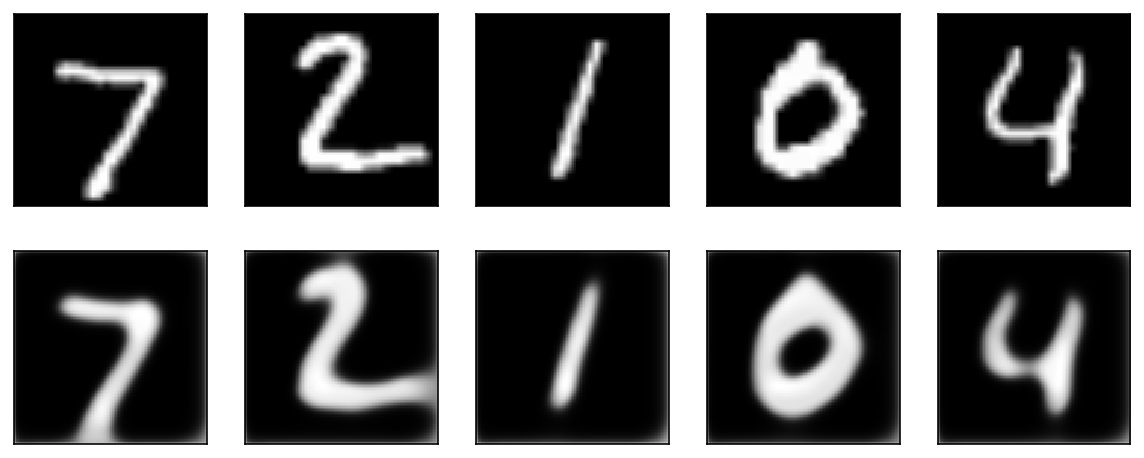

In [124]:
decoded_imgs = autoencoder.predict(x_test[:20])

n = 5                                        
plt.figure(figsize=(10, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n,i+n)
    plt.imshow(decoded_imgs[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<tf.Tensor 'max_pooling2d_5/Identity:0' shape=(None, 4, 4, 8) dtype=float32>

In [119]:
ts = decoded_imgs[2]
ts.shape

(128, 128, 1)

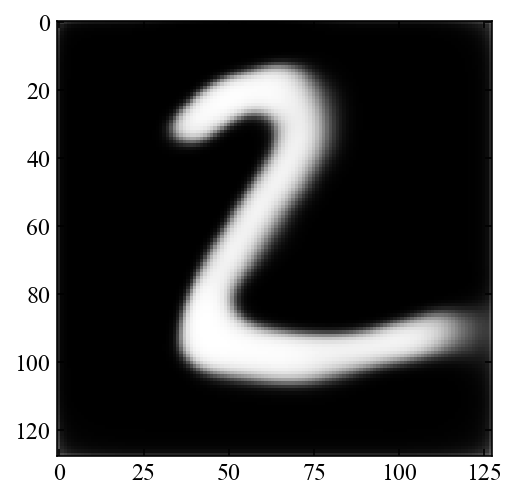

In [120]:
plt.imshow(ts.reshape(128,128),'gray')

In [110]:
ts = decoded_imgs[0]
ts=ts[None,...]

ts = Conv2DTranspose(1, (3, 3), strides=(2,2), activation='relu', padding='same')(ts)
ts = Conv2DTranspose(1, (3, 3), strides=(2,2), activation='relu', padding='same')(ts)
ts = Conv2DTranspose(1, (3, 3), strides=(2,2), activation='relu', padding='same')(ts)
ts = Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')(ts)
ts = ts[0,:,:,0]
ts.shape

TensorShape([448, 448])

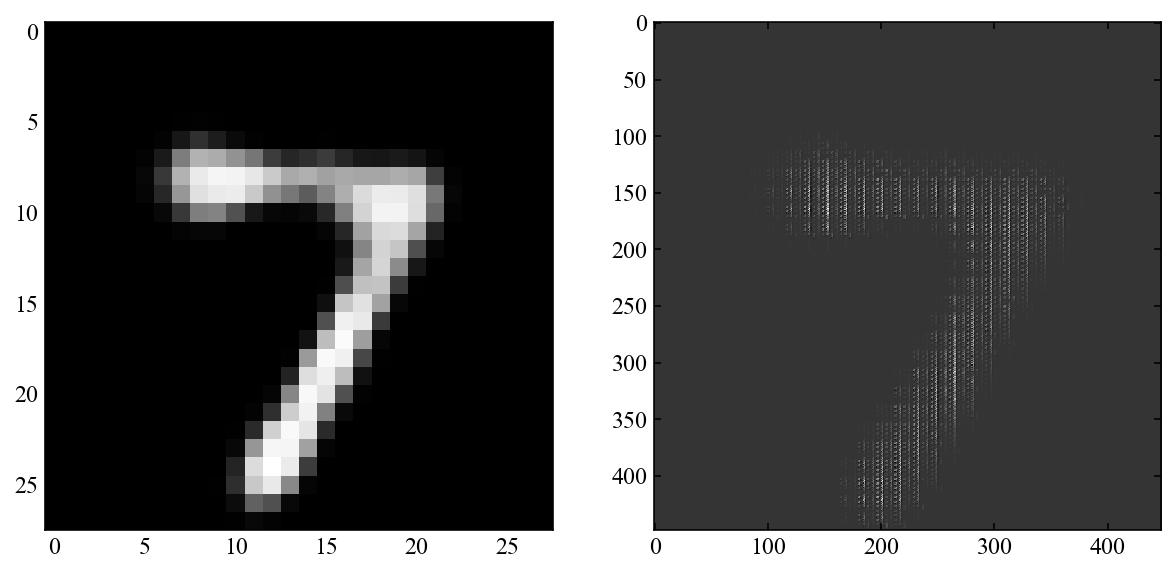

In [111]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(ts0[...,-1])
plt.subplot(1,2,2)
plt.imshow(ts,'gray')

In [130]:
ts0 = decoded_imgs[0]
ts=ts0[None,...]

ts = UpSampling2D((5,5))(ts)
ts = Conv2D(1, (5,5), strides=(2,2),  padding='same')(ts)
ts = UpSampling2D((5,5))(ts)
ts = Conv2D(1, (5,5), strides=(2,2),  padding='same')(ts)
# ts = UpSampling2D((10,10))(ts)
ts = Conv2D(1,(3,3), activation='sigmoid')(ts)
ts = ts[0,:,:,0]
ts.shape

TensorShape([173, 173])

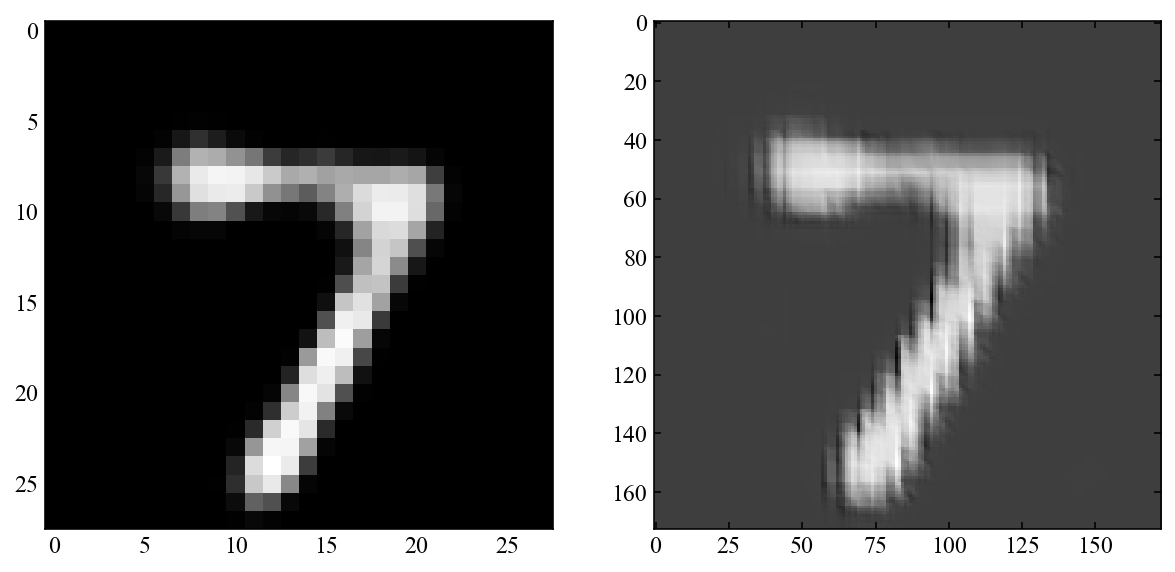

In [131]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(ts0[...,-1])
plt.subplot(1,2,2)
plt.imshow(ts,'gray')

In [125]:
import guang

In [126]:
from guang.DL.Model.cae import CAE

In [131]:
cae = CAE(128,128, 1)

In [132]:
cae.compile()

In [133]:
cae.fit(X_train,X_test)

Train on 1001 samples, validate on 1001 samples
Epoch 1/5
1001/1001 [==============================] - 46s 46ms/sample - loss: 0.6871 - val_loss: 0.6755
Epoch 2/5
1001/1001 [==============================] - 45s 45ms/sample - loss: 0.6600 - val_loss: 0.6300
Epoch 3/5
1001/1001 [==============================] - 45s 45ms/sample - loss: 0.5934 - val_loss: 0.5248
Epoch 4/5
1001/1001 [==============================] - 48s 48ms/sample - loss: 0.4677 - val_loss: 0.3803
Epoch 5/5
1001/1001 [==============================] - 52s 52ms/sample - loss: 0.3511 - val_loss: 0.2891
